- Part of code from Y. Chen

- Written by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
solver = scipy.integrate.solve_ivp
from numpy import sin, cos 
import matplotlib.pyplot as plt
import random

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
#parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (
              g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) 
            - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv
            ) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (
              g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) 
            + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)
            ) / (l2*(m/m2-cosv*cosv))
  return dvdt


In [3]:
# --- Modification for HNN(q,p): momentum computation function ---

def compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2):
    """
    With (q, v) input, computes momentum (p).
    Uses exact equations derived from double pendulum Lagrangian.
    """
    cos_q1q2 = np.cos(q1 - q2)
    
    # p1 = dL/dv1
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    
    # p2 = dL/dv2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    
    return p1, p2

# -----------------------------------------------------

In [4]:
def mass_matrix(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed. q1, q2 are (M,) shaped array.
    return shape: (M, 2, 2)
    """
    cos12 = np.cos(q1 - q2)

    # M11, M12, M22 are (M,) shaped
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2

    # (M, 2, 2) shapeed array creation
    M_q = np.zeros((q1.shape[0], 2, 2))
    M_q[:, 0, 0] = M11
    M_q[:, 0, 1] = M12
    M_q[:, 1, 0] = M12 # M21 (symmetric)
    M_q[:, 1, 1] = M22
    return M_q



In [5]:

def mass_matrix_dot(q1, v1, q2, v2, m1, m2, l1, l2):
    """ 
    dM/dt matrix is computed (M_dot). 
    q1, q2, v1, v2 are (M,) shaped numpy arrays.
    return shape: (M, 2, 2)
    """
    sin12 = np.sin(q1 - q2)
    delta_v = v1 - v2

    # --- All are (M,) shaped array ---
    # Since M11 is a constant, M_dot11 = 0
    # Differentiation of M12 = m2 * l1 * l2 * cos(q1-q2) gives rise to
    # M_dot12 = -m2 * l1 * l2 * sin(q1-q2) * (v1-v2)
    M_dot11 = np.zeros_like(q1)  # M11 is a constant, thus M_dot22 = 0
    M_dot12 = -m2 * l1 * l2 * sin12 * delta_v
    M_dot22 = np.zeros_like(q1) # M22 is a constant, thus M_dot22 = 0

    # (M, 2, 2) shaped array creation
    M_dot = np.zeros((q1.shape[0], 2, 2))
    M_dot[:, 0, 0] = M_dot11
    M_dot[:, 0, 1] = M_dot12
    M_dot[:, 1, 0] = M_dot12 # M_dot21 (symmetric)
    M_dot[:, 1, 1] = M_dot22
    
    return M_dot

In [6]:
def compute_dp_dt_accurate(q1, v1, q2, v2, a1, a2, m1, m2, l1, l2):
    """ 
    Using the formula M*a + M_dot*v, computes exact dp/dt.
    all input should be (M,).
    returns dp1_dt, dp2_dt of shape (M,).
    """
    # (M, 2, 2)
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2) 
    
    M_dot = mass_matrix_dot(q1, v1, q2, v2, m1, m2, l1, l2)

    # Acceleration a and Velocity v: (M, 2)
    a_vec = np.vstack([a1, a2]).T
    v_vec = np.vstack([v1, v2]).T

    # M*a computation: (M, 2, 2) @ (M, 2) -> (M, 2)
    M_a = np.einsum('Nij, Nj->Ni', M_q, a_vec)

    # M_dot*v computation: (M, 2, 2) @ (M, 2) -> (M, 2)
    M_dot_v = np.einsum('Nij, Nj->Ni', M_dot, v_vec) 

    # dp/dt (M, 2)
    dp_dt_vec = M_a + M_dot_v 
    
    dp1_dt = dp_dt_vec[:, 0]
    dp2_dt = dp_dt_vec[:, 1]
    
    return dp1_dt, dp2_dt

In [7]:
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000 # number of samples for initial state vectors
x1_init = np.random.randn(num) # not used but kept to match the random number
x2_init = np.random.randn(num) # not used but kept to match the random number
v1_init = np.random.randn(num) # not used but kept to match the random number
v2_init = np.random.randn(num) # not used but kept to match the random number
state = np.random.randn(num, 4) # state vectors: initial values sample

# In order to have the numbers in (q1, q2, v1, v2) order be 
# the SAME as those in (q1, v1, q2, v2) order used in the original code of Y. Chen,
# we do not touch random number generation, but need to swap 1 and 2.
temp = state[:, 1]
state[:, 1] = state[:, 2]
state[:, 2] = temp

x_input_qp = []
x_target_qp = [] # HNN's target must be in (dq, dp) form

x_input_qp_list = []
x_target_qp_list = []

for i in range(num):
    sol = solver(func, [0, tend], state[i], t_eval=t_eval)
    q1, q2, v1, v2 = sol['y'] # (M,) shape
    
    p1_val, p2_val = compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2)

    # (M, 4) shape (time axis first)
    x_input_qp_val = np.vstack([q1, q2, p1_val, p2_val]).T 

    dxdt_qv = func(None, sol['y']) 
    dq1_dt, dq2_dt, dv1_dt, dv2_dt = dxdt_qv
    dp1_dt, dp2_dt = compute_dp_dt_accurate(q1, v1, q2, v2, dv1_dt, dv2_dt, m1, m2, l1, l2)
    
    # (M, 4) shape
    x_target_qp_val = np.vstack([dq1_dt, dq2_dt, dp1_dt, dp2_dt]).T 

    x_input_qp_list.append(x_input_qp_val)
    x_target_qp_list.append(x_target_qp_val)

x_input_qp = np.concatenate(x_input_qp_list, axis=0) # Shape (M*num, 4)
x_target_qp = np.concatenate(x_target_qp_list, axis=0) # Shape (M*num, 4)

# Data normalization:
# Unlike Y. Chen, I take input scale and target scale separately!
x_target_max = np.abs(x_target_qp).max(axis=0)
x_input_max = np.abs(x_input_qp).max(axis=0)
A = np.diag(x_target_max) # Shape (4, 4)
B = np.diag(x_input_max) # Now, B differs from A.


x_input_scaled = x_input_qp @ np.linalg.inv(B)
x_target_scaled = x_target_qp @ np.linalg.inv(A)

np.savetxt("hnn_input_dp_qp_sep_sc.csv", x_input_scaled, delimiter=',')
np.savetxt("hnn_target_dp_qp_sep_sc.csv", x_target_scaled, delimiter=',')


A_file = np.savetxt("hnn_A_dp_qp_sep_sc.csv", A, delimiter=',')
B_file = np.savetxt("hnn_B_dp_qp_sep_sc.csv", B, delimiter=',')


Check Data

In [8]:
import numpy as np
import pandas as pd
A = pd.read_csv("./hnn_A_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./hnn_B_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)
x_input_scaled = pd.read_csv("./hnn_input_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
x_target_scaled = pd.read_csv("./hnn_target_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
x_input_scaled = np.asmatrix(x_input_scaled)
x_target_scaled = np.asmatrix(x_target_scaled)

print('A matrix:\n', A)
print('B matrix:\n', B)
print('x_input_scaled shape:', x_input_scaled.shape)
print('x_target_scaled shape:', x_target_scaled.shape)

A matrix:
 [[ 14.132842   0.         0.         0.      ]
 [  0.        16.193363   0.         0.      ]
 [  0.         0.       142.7655     0.      ]
 [  0.         0.         0.       139.11087 ]]
B matrix:
 [[21.906992  0.        0.        0.      ]
 [ 0.       27.135761  0.        0.      ]
 [ 0.        0.       23.931248  0.      ]
 [ 0.        0.        0.       19.520573]]
x_input_scaled shape: (200000, 4)
x_target_scaled shape: (200000, 4)


In [9]:
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# --- mass_matrix function modified to hande flexible input shape ---
def mass_matrix(q1, q2, m1, m2, l1, l2):
    cos12 = np.cos(q1 - q2)
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    # initialize M_q array upon input shape
    if np.ndim(q1) > 0:
        # q1 is array --> (..., 2, 2) array
        M_q = np.zeros(q1.shape + (2, 2))
    else:
        # q1 is scalar --> (2, 2) array
        M_q = np.zeros((2, 2))
    
    # value assignment using broadcasting
    M_q[..., 0, 0] = M11
    M_q[..., 0, 1] = M12
    M_q[..., 1, 0] = M12 # M21 (symmetric)
    M_q[..., 1, 1] = M22
    
    return M_q

def inv_mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """
    Computes analytically the inverse matrix M_inv 
    of the mass-matrix of the double pendulum system, M,
    Input q1, q2 are scaler or numpy array of the same shape.
    """
    cos12 = np.cos(q1 - q2)
    
    # M matrix elements
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    # Determinant computation
    detM = M11 * M22 - M12**2

    # Inverse matrix element computation
    InvM11 = M22 / detM
    InvM12 = -M12 / detM
    InvM22 = M11 / detM

    # Initialize M_q array upon input shape
    if np.ndim(q1) > 0:
        # q1 is array --> (..., 2, 2) shape
        M_inv = np.zeros(q1.shape + (2, 2))
    
    # Using broadcasting, values are assigned in (100, 2, 2) shape.
    M_inv[..., 0, 0] = InvM11
    M_inv[..., 0, 1] = InvM12
    M_inv[..., 1, 0] = InvM12
    M_inv[..., 1, 1] = InvM22

    return M_inv

def convert_qp_to_qv(q1_, q2_, p1_, p2_, m1, m2, l1, l2):
    """
    (q, p) orbit data is converted to (q, v) orbit data.
    input: (M,) or (M, 1) shaped numpy array.
    return value: (M,) array of tuple of (q1, q2, v1, v2)
    """
    print('p1_ shape (input):', p1_.shape)
    print('p2_ shape (input):', p2_.shape)

    # Execute when data is not empy
    if q1_.size > 0:
        # 1. Mass-matrix M(q) computation
        # q1, q2: (M,) --> M_q: (M, 2, 2)
        M_q = mass_matrix(q1_, q2_, m1, m2, l1, l2)
        print('M_q shape:', M_q.shape)

        # 2. Momentum vector p_vec preparation
        p_vec = np.column_stack([p1_, p2_]) # Shape: (M, 2)

        print('p_vec shape:', p_vec.shape)
                
        # 3. M's inverse matrix inv(M) computation
        inv_M = inv_mass_matrix_scalar(q1_, q2_, m1, m2, l1, l2)

        print('inv_M shape:', inv_M.shape)
        
        # 4. Velocity vector v_vec computation: v = inv(M) @ p 
        # (M, 2, 2) @ (M, 2) -> (M, 2)
        v_vec = np.einsum('Nij, Nj->Ni', inv_M, p_vec)
        
    else:
        # case when input data is only scalar
        v_vec = np.dot(np.linalg.inv(mass_matrix(q1_, q2_, m1, m2, l1, l2)), np.array([p1_, p2_]).flatten())
        
    # 5. Extract v1, v2 and return
    v1 = v_vec[..., 0]
    v2 = v_vec[..., 1]

    return q1_, q2_, v1, v2



x_input_original shape: (200000, 4)
x_target_original shape: (200000, 4)
Sample 0 / 2000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)
p1_ shape (input): (100,)
p2_ shape (input): (100,)
M_q shape: (100, 2, 2)
p_vec shape: (100, 2)
inv_M shape: (100, 2, 2)


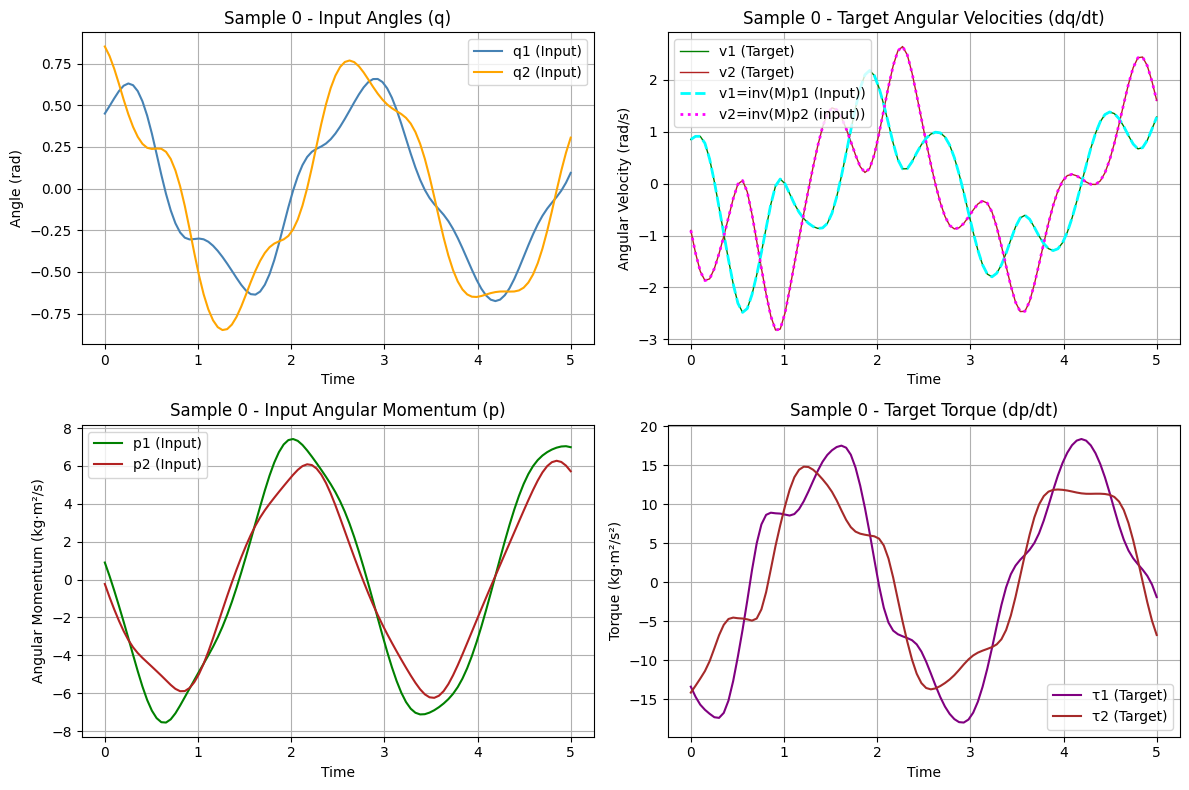

Sample 500 / 2000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)
p1_ shape (input): (100,)
p2_ shape (input): (100,)
M_q shape: (100, 2, 2)
p_vec shape: (100, 2)
inv_M shape: (100, 2, 2)


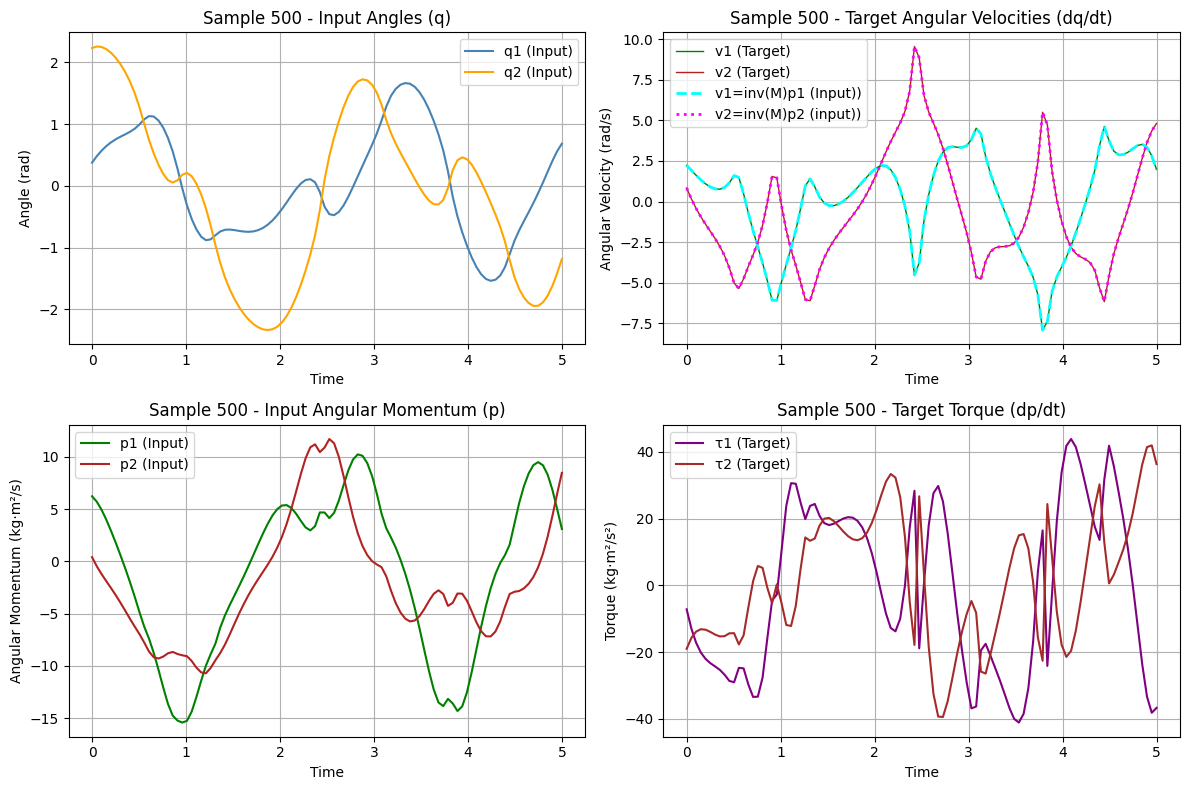

Sample 1000 / 2000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)
p1_ shape (input): (100,)
p2_ shape (input): (100,)
M_q shape: (100, 2, 2)
p_vec shape: (100, 2)
inv_M shape: (100, 2, 2)


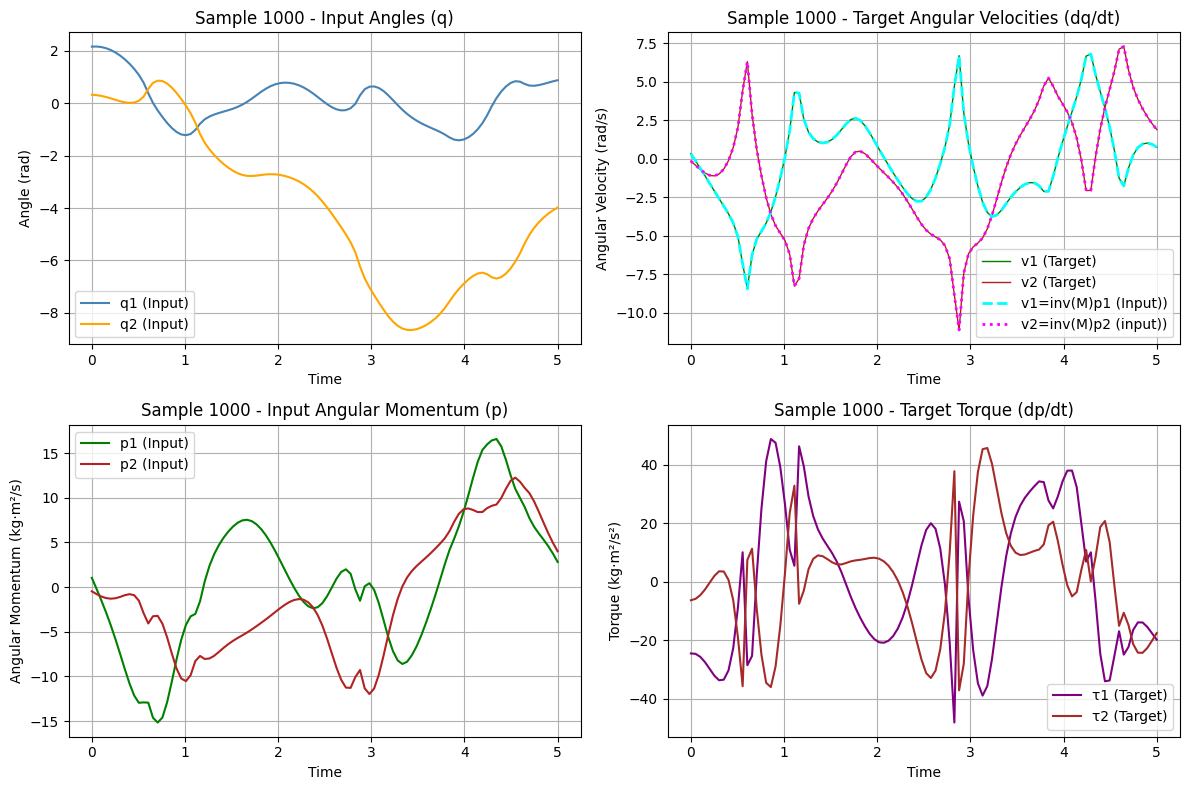

Sample 1500 / 2000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)
p1_ shape (input): (100,)
p2_ shape (input): (100,)
M_q shape: (100, 2, 2)
p_vec shape: (100, 2)
inv_M shape: (100, 2, 2)


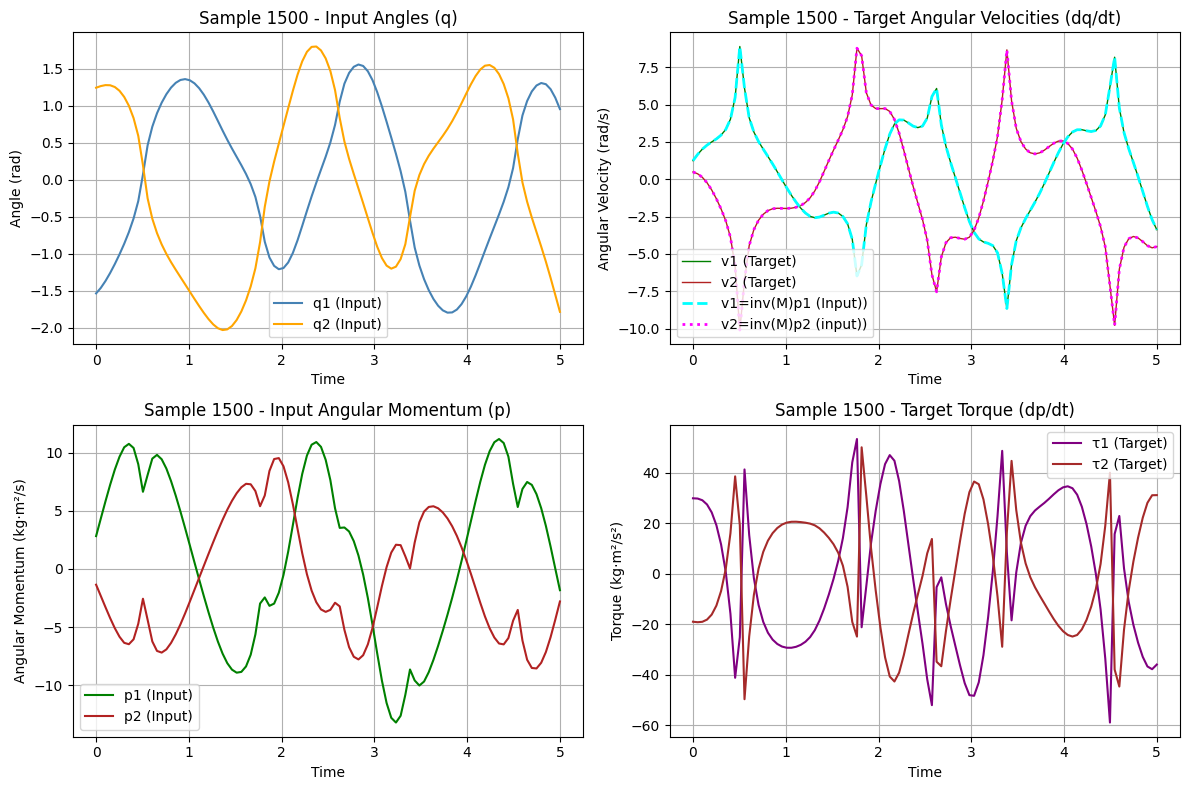

In [10]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000 # number of samples for initial state vectors
x_input_original = B @ x_input_scaled.T
x_input_original = x_input_original.T
x_target_original = A @ x_target_scaled.T # Now, B differs from A
x_target_original = x_target_original.T
print('x_input_original shape:', x_input_original.shape)
print('x_target_original shape:', x_target_original.shape)  

for i in range(num):
  if i % 500 == 0:
    print(f'Sample {i} / {num} processed.')
    print('x_input_original slice shape:', x_input_original[i*M:(i+1)*M, :].shape)

    data_slice = x_input_original[i*M:(i+1)*M, 0:1] # Shape (100, 1) 또는 (1, 100)
    
    q1 = np.array(data_slice.tolist()).reshape(-1)
    q2 = np.array(x_input_original[i*M:(i+1)*M, 1:2].tolist()).reshape(-1)
    p1 = np.array(x_input_original[i*M:(i+1)*M, 2:3].tolist()).reshape(-1)
    p2 = np.array(x_input_original[i*M:(i+1)*M, 3:4].tolist()).reshape(-1)
    
    print('p1 shape after list conversion:', p1.shape)

    Q1, Q2, V1, V2 = convert_qp_to_qv(q1, q2, p1, p2, m1, m2, l1, l2)
    
    plt.figure(figsize=(12, 8)) # 2x2 layout

    # Subplot 1 (Top_Left): Input q1, q2
    plt.subplot(2, 2, 1)
    plt.title(f'Sample {i} - Input Angles (q)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 0], label='q1 (Input)', color='steelblue')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 1], label='q2 (Input)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()

    # Subplot 2 (Top-Right): Target q derivative (i.e., dq1/dt, dq2/dt)
    plt.subplot(2, 2, 2)
    plt.title(f'Sample {i} - Target Angular Velocities (dq/dt)')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 0], label='v1 (Target)', color='g',lw=1)
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 1], label='v2 (Target)', color='firebrick', lw=1)
    # For comparison with Input p1, p2, drawn in dashed lines.
    plt.plot(t_eval, V1, label='v1=inv(M)p1 (Input))', color='cyan', linestyle='--',lw=2)
    plt.plot(t_eval, V2, label='v2=inv(M)p2 (input))', color='magenta', linestyle=':',lw=2)

    plt.xlabel('Time')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.grid(True)
    plt.legend()


    # Subplot 3 (Bottom-Left): Input p1, p2
    plt.subplot(2, 2, 3)
    plt.title(f'Sample {i} - Input Angular Momentum (p)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 2], label='p1 (Input)', color='g')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 3], label='p2 (Input)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Angular Momentum (kg·m²/s)')
    plt.grid(True)
    plt.legend()

    # Subplot 4 (Bottom-Right): Target p derivatives (i.e., Torques τ1, τ2)
    plt.subplot(2, 2, 4)
    plt.title(f'Sample {i} - Target Torque (dp/dt)')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 2], label='τ1 (Target)', color='purple')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 3], label='τ2 (Target)', color='brown')
    plt.xlabel('Time')
    plt.ylabel('Torque (kg·m²/s²)')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()




Sample 0 / 2000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


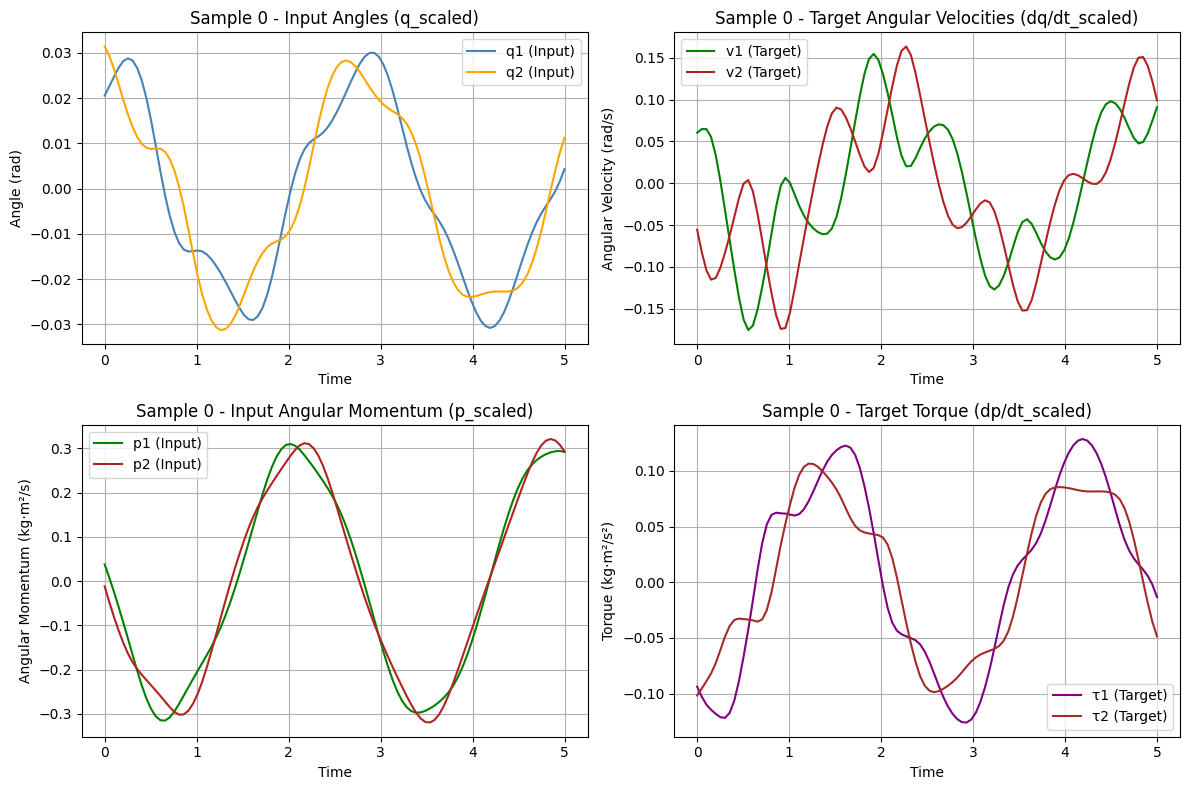

Sample 500 / 2000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


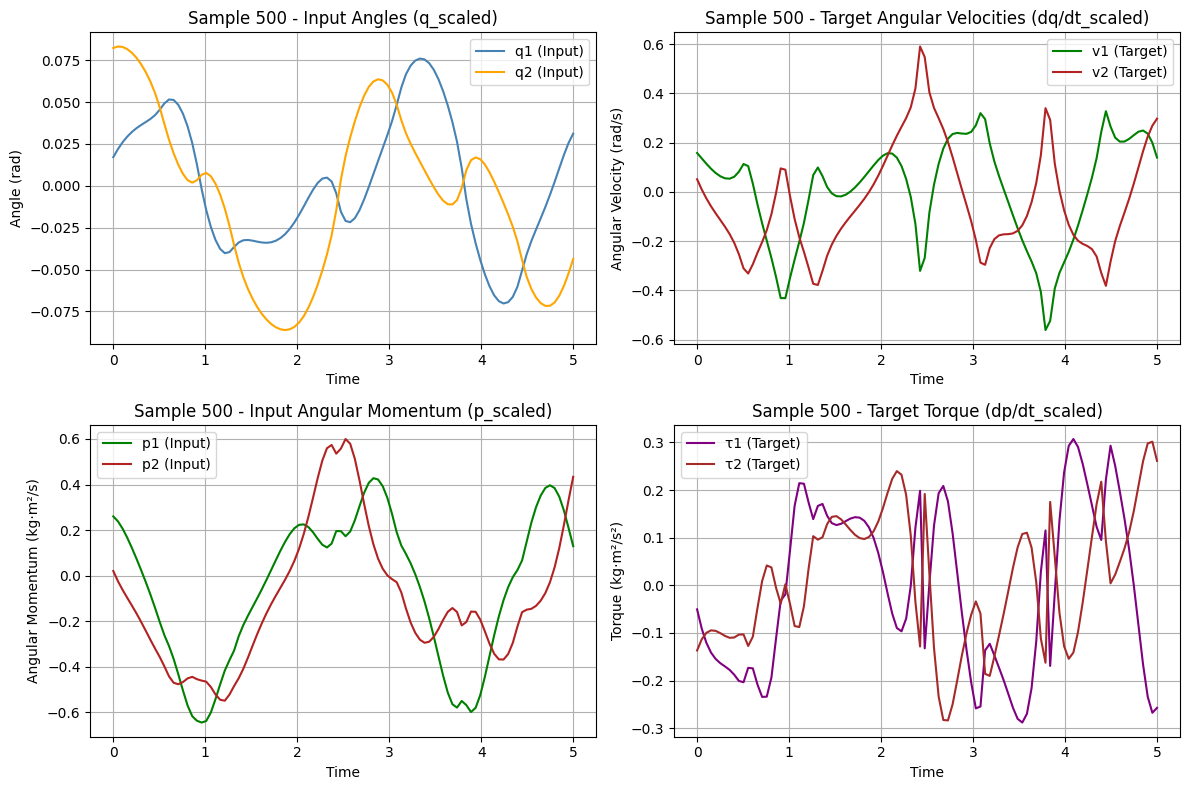

Sample 1000 / 2000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


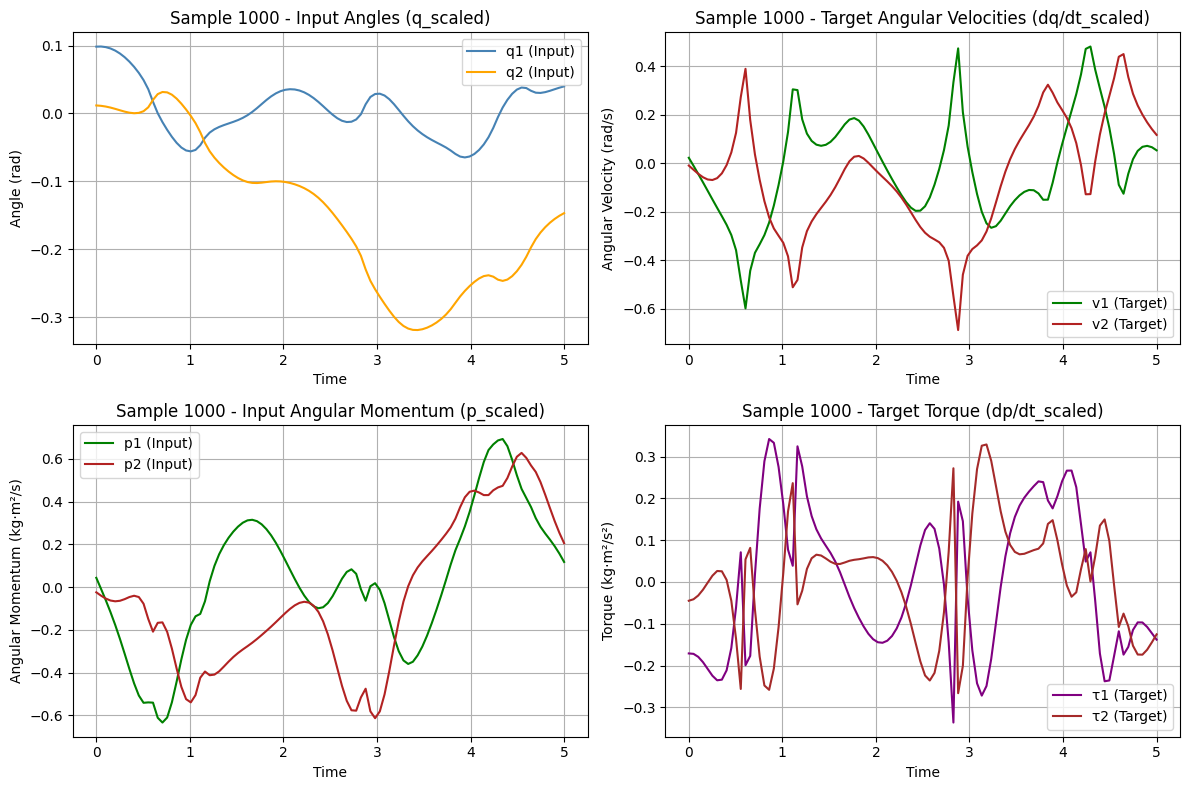

Sample 1500 / 2000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


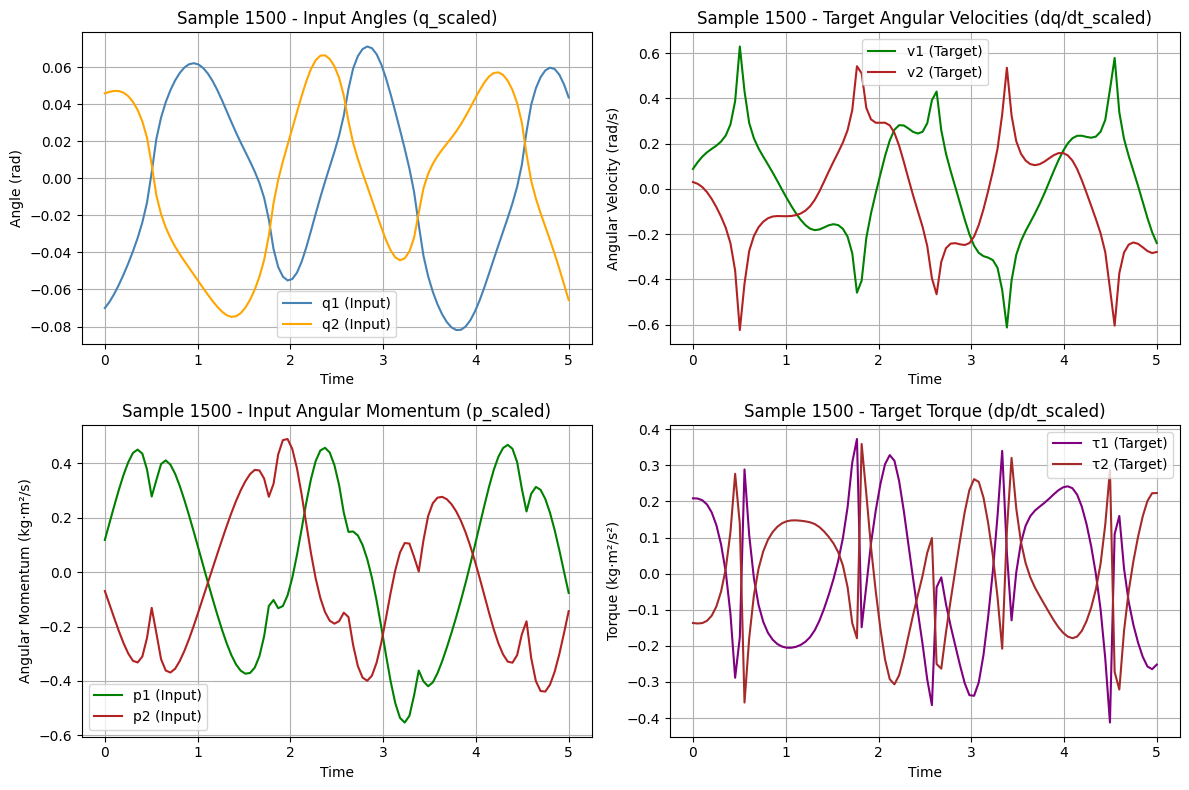

In [11]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 2000 # number of samples for initial state vectors

for i in range(num):
  if i % 500 == 0:
    print(f'Sample {i} / {num} processed.')
    print('x_input_scaled slice shape:', x_input_scaled[i*M:(i+1)*M, :].shape)

    data_slice = x_input_original[i*M:(i+1)*M, 0:1] # Shape (100, 1) 또는 (1, 100)
    
    q1 = np.array(data_slice.tolist()).reshape(-1)
    q2 = np.array(x_input_scaled[i*M:(i+1)*M, 1:2].tolist()).reshape(-1)
    p1 = np.array(x_input_scaled[i*M:(i+1)*M, 2:3].tolist()).reshape(-1)
    p2 = np.array(x_input_scaled[i*M:(i+1)*M, 3:4].tolist()).reshape(-1)
    
    print('p1 shape after list conversion:', p1.shape)

    plt.figure(figsize=(12, 8)) # 2x2 layout

    # Subplot 1 (Top-Left): Input q1, q2
    plt.subplot(2, 2, 1)
    plt.title(f'Sample {i} - Input Angles (q_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 0], label='q1 (Input)', color='steelblue')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 1], label='q2 (Input)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()

    # Subplot 2 (Top-Right): Target q derivatives (i.e., dq1/dt, dq2/dt)
    plt.subplot(2, 2, 2)
    plt.title(f'Sample {i} - Target Angular Velocities (dq/dt_scaled)')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 0], label='v1 (Target)', color='g')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 1], label='v2 (Target)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.grid(True)
    plt.legend()


    # Subplot 3 (Bottom-Left): Input p1, p2
    plt.subplot(2, 2, 3)
    plt.title(f'Sample {i} - Input Angular Momentum (p_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 2], label='p1 (Input)', color='g')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 3], label='p2 (Input)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Angular Momentum (kg·m²/s)')
    plt.grid(True)
    plt.legend()

    # Subplot 4 (Bottom-Right): Target p derivatives (i.e., Torque τ1, τ2)
    plt.subplot(2, 2, 4)
    plt.title(f'Sample {i} - Target Torque (dp/dt_scaled)')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 2], label='τ1 (Target)', color='purple')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 3], label='τ2 (Target)', color='brown')
    plt.xlabel('Time')
    plt.ylabel('Torque (kg·m²/s²)')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()
